In [1]:
from __future__ import absolute_import
from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()

import numpy as np
import os
import gzip
import struct
import array
import random
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels


def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
    cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    return cax

def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
#    fig.patch.set_visible(False)   <--- off because of error
    ax.patch.set_visible(False)
    plt.savefig(filename)


In [2]:
N_data, train_images, train_labels, test_images, test_labels = load_mnist()

print(N_data)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


60000
(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [3]:
# Initialize datasets: Train-10,000 binarized samples / Test-10,000 binarized samples 
 
for i in range(train_images.shape[0]):
    for j in range(train_images.shape[1]):
        if train_images[i,j] > 0.5: 
            train_images[i,j] = 1
        else:
            train_images[i,j] = 0

for i in range(test_images.shape[0]):
    for j in range(test_images.shape[1]):
        if test_images[i,j] > 0.5: 
            test_images[i,j] = 1
        else:
            test_images[i,j] = 0            
            
train_images = train_images[0:10000,:]
train_labels = train_labels[0:10000,:] 

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(10000, 784)
(10000, 10)
(10000, 784)
(10000, 10)


[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


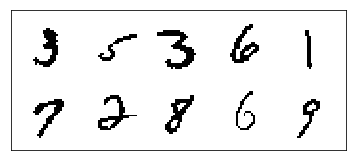

In [4]:
# Initialize dataset test
fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(111)
plot_images(train_images[10:20,:], ax)
print(train_labels[10:20])

c:\users\eodus\anaconda3\envs\tensorflow_gpu\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


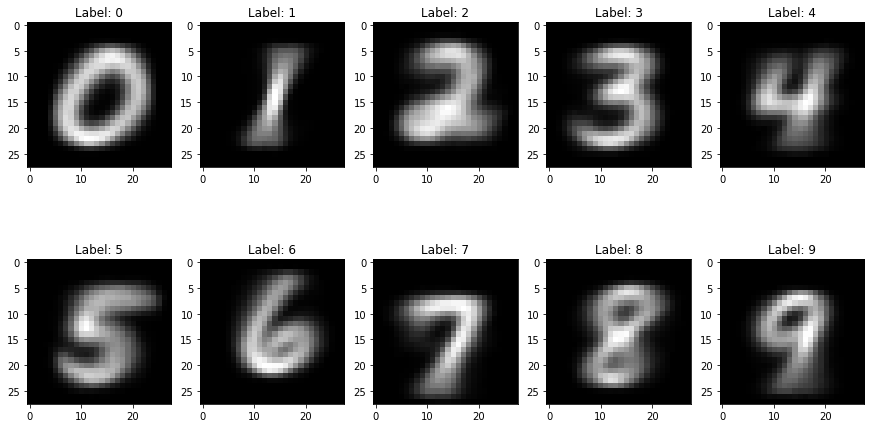

In [5]:
######### Problem 1 (C) ##########
# train_images: 10000x784 train_labels: 10000x10 
a=2 #beta
b=2 #beta
theta = np.zeros((784,10)) #theta (784x10)
                        
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        _, counts = np.unique(train_labels[:,j], return_counts=True)
        num = counts[1] # number of dataset for specific label
        theta[i,j] = np.sum(train_images[np.where(train_labels[:,j]==1),i])
        theta[i,j] = (theta[i,j] + a - 1) / (num + a + b - 2)

plt.figure(figsize=(15,8))

for i in range(10):
    theta_img = np.reshape(theta[:,i], [28,28])        
    ax = fig.add_subplot(222)
    ax1 = plt.subplot(2,5,i+1)
    ax1.imshow(theta_img, cmap='gray')
    ax1.set_title("Label: {}".format(i),fontsize=12)

    
    

In [6]:
######### Problem 1 (E) ##########

pi = 1/10
log_likelihood_train = np.zeros((train_images.shape[0],10)) # 10000x10
log_likelihood_test = np.zeros((test_images.shape[0],10)) # 10000x10

for i in range(train_images.shape[0]): #10000
    for label in range(10): #label
        for ii in range(train_images.shape[1]): #784 
            log_likelihood_train[i, label] += train_images[i,ii]*np.log(theta[ii,label]) + (1-train_images[i,ii])*np.log(1-theta[ii,label])
            log_likelihood_test[i, label] += test_images[i,ii]*np.log(theta[ii,label]) + (1-test_images[i,ii])*np.log(1-theta[ii,label])
        
        log_likelihood_train[i,label] += np.log(pi)
        log_likelihood_test[i,label] += np.log(pi)



In [7]:
avg_log_likelihood_train = 0
avg_log_likelihood_test = 0
for i in range(train_images.shape[0]):
    
    avg_log_likelihood_train += log_likelihood_train[i,list(train_labels[i,:]).index(1)] / train_images.shape[0]# See only true target
    avg_log_likelihood_test += log_likelihood_test[i,list(test_labels[i,:]).index(1)] / test_images.shape[0] # See only true target

    
print('Avg Train likelihood: ',avg_log_likelihood_train)
print('Avg Test likelihood: ',avg_log_likelihood_test)
    

train_accuracy = 0
test_accuracy = 0
for i in range(train_images.shape[0]):
    label_train = list(train_labels[i,:]).index(1)
    label_test =  list(test_labels[i,:]).index(1)
    
    if np.argmax(np.exp(log_likelihood_train[i,:])) == label_train:
        train_accuracy += 1 / train_images.shape[0]
        
    if np.argmax(np.exp(log_likelihood_test[i,:])) == label_test:
        test_accuracy += 1 / test_images.shape[0]

print('Train Accuracy: %.3f' %train_accuracy)
print('Test Accuracy: %.3f' %test_accuracy)
  
    
    


Avg Train likelihood:  -172.35382334668697
Avg Test likelihood:  -173.043603091204
Train Accuracy: 0.840
Test Accuracy: 0.837


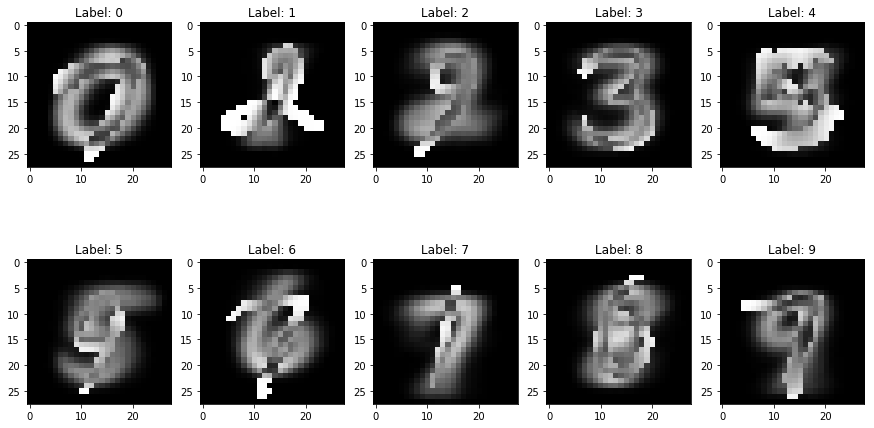

In [8]:
######## Problem 2 (C) ########## 
# Train data which does not always have same label as first sampled class
random_img = np.zeros((784,10))

for c in range(10):
    
    loc_choice = np.random.choice(10000) # Random sample from locations
    for i in range(len(random_img)): # Produce random image 
        random_img[i,c] = (theta[i,c]**(train_images[loc_choice,i])) * ((1-theta[i,c])**(1-train_images[loc_choice,i]))
    
    
plt.figure(figsize=(15,8))
for i in range(10):
    result_img = np.reshape(1 - random_img[:,i], [28,28]) 
    ax2 = fig.add_subplot(222)

    ax2 = plt.subplot(2,5,i+1)
    ax2.imshow(result_img, cmap='gray')
    ax2.set_title("Label: {}".format(i),fontsize=12)
    



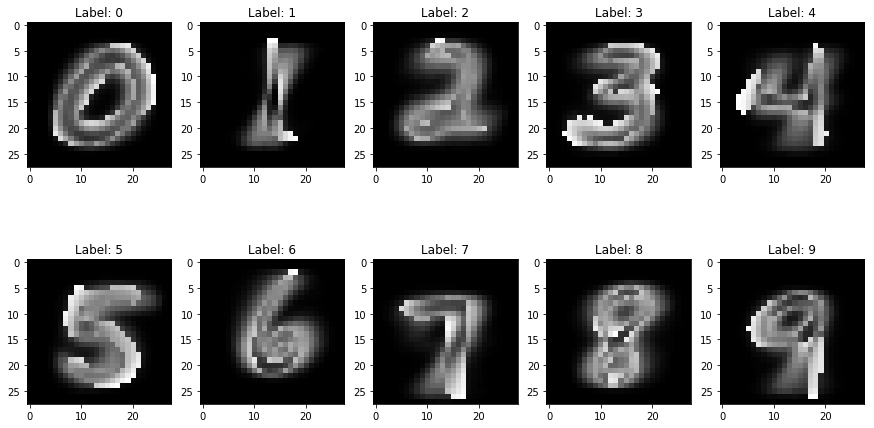

In [9]:
####### Problem 2 (C) ########## 
# Train data which has same label as first sampled class
random_img = np.zeros((784,10))

for c in range(10):
    loc_c = np.array([])
    for i in range(train_labels.shape[0]):   
        if c==list(train_labels[i,:]).index(1): # Find locations of train data with specific class
            loc_c = np.concatenate((loc_c, np.array([i]))) # Vectorize
    loc_choice = int(np.random.choice(loc_c)) # Random sample from locations
    for i in range(len(random_img)): # Produce random image 
        random_img[i,c] = (theta[i,c]**(train_images[loc_choice,i])) * ((1-theta[i,c])**(1-train_images[loc_choice,i]))
    
    
plt.figure(figsize=(15,8))
for i in range(10):
    result_img = np.reshape(1 - random_img[:,i], [28,28]) 
    ax2 = fig.add_subplot(222)

    ax2 = plt.subplot(2,5,i+1)
    ax2.imshow(result_img, cmap='gray')
    ax2.set_title("Label: {}".format(i),fontsize=12)
    



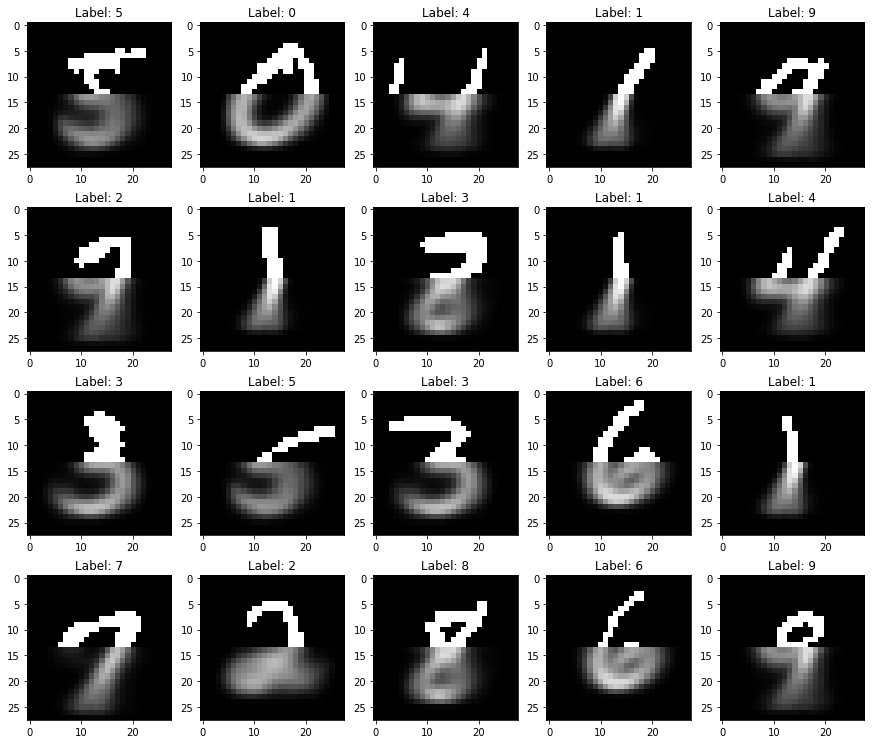

In [10]:
######## Problem 2 (E) ##########

pi = 1/10
plt.figure(figsize=(15,13))

for n in range(20):
    posterior_for_predict = np.ones((10,1))

    for i in range(len(posterior_for_predict)):
        for d in range(int(train_images.shape[1]/2)):
            posterior_for_predict[i] = posterior_for_predict[i] * (theta[d,i]**(train_images[n,d])) * ((1-theta[d,i])**(1-train_images[n,d])) 

    posterior_for_predict = posterior_for_predict / np.mean(posterior_for_predict) #Use normalize for better visualization


    temp = np.zeros((int(train_images.shape[1]/2),))
    for j in range(len(temp)):
        for c in range(len(posterior_for_predict)):
            temp[j] +=  (theta[j+392,c])*pi*posterior_for_predict[c] #Bottom prediction

    result_img2 = np.zeros((784,))

    result_img2[0:392] = train_images[n,0:392]
    result_img2[392:] = temp 

    result_img2 = np.reshape(result_img2, [28, 28])

    ax3 = fig.add_subplot(333)

    ax3 = plt.subplot(4,5,n+1)
    ax3.imshow(result_img2, cmap='gray')
    ax3.set_title("Label: {}".format(list(train_labels[n,:]).index(1)))

    
    

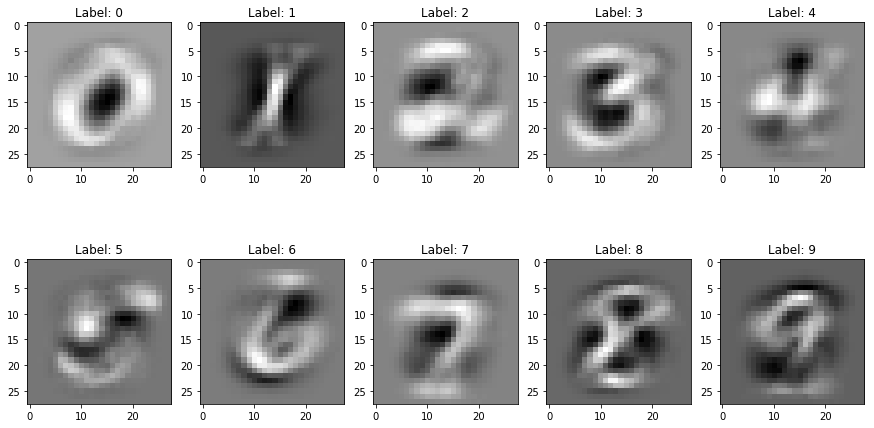

In [11]:
########### Problem 3 (C) ###########

Weight = np.zeros((28*28,10))
gradient = np.zeros((28*28,10))
y_predicted = np.zeros((train_images.shape[0],10))

Iter = 1000
learning_rate = 0.01

for i in range(Iter):
    z = np.dot(train_images, Weight)
    y_predicted = np.divide(np.exp(z),np.reshape(np.exp(logsumexp(z, axis=1)), [train_images.shape[0],1]))
    gradient = np.dot(train_images.T ,(train_labels - y_predicted))

    Weight = Weight + (learning_rate/train_images.shape[0]) * gradient # Gradient ascent
    

plt.figure(figsize=(15,8))

for i in range(10):
    result_img3 = np.reshape(Weight[:,i], [28, 28])

    ax4 = fig.add_subplot(333)
    ax4 = plt.subplot(2,5,i+1)
    ax4.imshow(result_img3, cmap='gray')
    ax4.set_title("Label: {}".format(i))
    


In [13]:
########### Problem 3 (D) ###########
z_train = np.dot(train_images, Weight)
z_test = np.dot(test_images, Weight)


log_likelihood_train2 = np.subtract(z_train, np.reshape(logsumexp(z_train ,axis=1), [train_images.shape[0],1]))  #10000x10
log_likelihood_test2 = np.subtract(z_test, np.reshape(logsumexp(z_test ,axis=1), [test_images.shape[0],1]))  #10000x10

avg_log_likelihood_train2 = 0
avg_log_likelihood_test2 = 0

for i in range(train_images.shape[0]):
        
    avg_log_likelihood_train2 += log_likelihood_train2[i,list(train_labels[i,:]).index(1)] / train_images.shape[0] # See only true target
    avg_log_likelihood_test2 += log_likelihood_test2[i,list(test_labels[i,:]).index(1)] / test_images.shape[0]# See only true target


print('Avg Train likelihood: ',avg_log_likelihood_train2)
print('Avg Test likelihood: ',avg_log_likelihood_test2)

train_accuracy2 = 0
test_accuracy2 = 0

for i in range(train_images.shape[0]):
    label_train2 = list(train_labels[i,:]).index(1)
    label_test2 =  list(test_labels[i,:]).index(1)
    
    if np.argmax(np.exp(log_likelihood_train2[i,:])) == label_train2:
        train_accuracy2 += 1 / train_images.shape[0]
        
    if np.argmax(np.exp(log_likelihood_test2[i,:])) == label_test2:
        test_accuracy2 += 1 / test_images.shape[0]

print('Train Accuracy: %.3f' %train_accuracy2)
print('Test Accuracy: %.3f' %test_accuracy2)
      

Avg Train likelihood:  -0.5801250483937322
Avg Test likelihood:  -0.5890940388848332
Train Accuracy: 0.868
Test Accuracy: 0.865


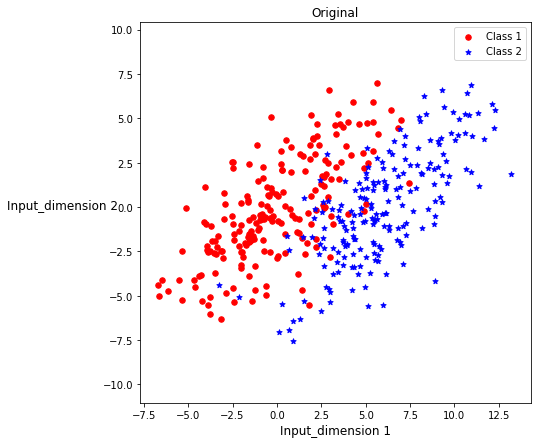

In [28]:
############ Problem 4 (A) #############
N = 400
D = 2
K = 2
u_1 = [0.1, 0.1]
u_2 = [6.0, 0.1]
sigma = [[10,7],[7,10]] #Diagonal Covariance

data_1 = np.random.multivariate_normal(u_1, sigma, int(N/2))
data_2 = np.random.multivariate_normal(u_2, sigma, int(N/2))

fig_original = plt.figure(figsize=(7,7))
marker_size = 30
plt.scatter(data_1[:,0], data_1[:,1], marker_size, marker='o', c='red')
plt.scatter(data_2[:,0], data_2[:,1], marker_size, marker='*', c='blue')

plt.title('Original', fontsize=12)
plt.xlabel('Input_dimension 1', fontsize=12)
plt.ylabel('Input_dimension 2', rotation=0, fontsize=12, labelpad=40)
plt.axis('equal')
plt.gca().legend(('Class 1','Class 2'))
plt.show()
#fig_original.savefig('Problem4_A.png',bbox_inches='tight')
            
data = np.concatenate((data_1, data_2), axis=0)            
            
    
    

In [15]:
############ Problem 4 K-mean function #############

def cost(u1,u2,r,data):
    cost = 0
    
    for i in range(N):
        if r[i,0] == 1:
            cost += np.linalg.norm(u1-data[i,:])
        elif r[i,1] == 1:
            cost += np.linalg.norm(u2-data[i,:])

    
    return cost
    

In [16]:
def km_e_step(u1,u2,data):
    r = np.zeros((N,K))
    
    for i in range(N):
        temp_1 = np.linalg.norm(u_1_k-data[i,:])
        temp_2 = np.linalg.norm(u_2_k-data[i,:])
    
        if temp_1 < temp_2:
            r[i,0] = 1
        else:
            r[i,1] = 1
    
    return r

In [17]:
def km_m_step(r,data):
    
    u1 = (np.dot(data.T,r[:,0]))/ np.sum(r[:,0])
    u2 = (np.dot(data.T,r[:,1]))/ np.sum(r[:,1])

    return u1,u2

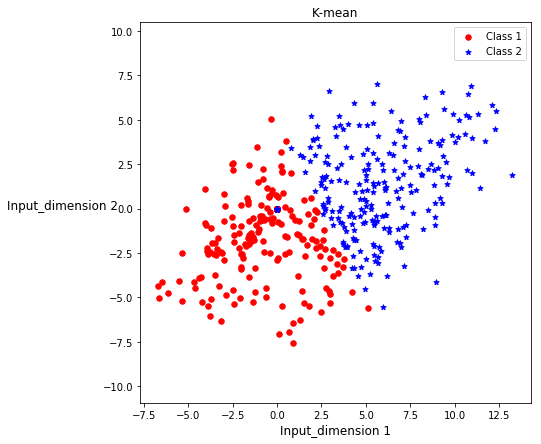

In [29]:
############ Problem 4 (B) #############

# Initialize
u_1_k = [0, 0]
u_2_k = [1, 1]
cost_k = np.zeros((20,1))
thres = 0.00001

for i in range(len(cost_k)):
    # E-step
    r_k = km_e_step(u_1_k,u_2_k,data)
    
    # M-step
    u_1_k, u_2_k = km_m_step(r_k,data)
    cost_k[i] = cost(u_1_k,u_2_k,r_k,data)
    if i>0:
        if np.linalg.norm(cost_k[i] - cost_k[i-1]) < thres:
            break


            
data_1_kmean = np.multiply(data.T,r_k[:,0]).T
data_2_kmean = np.multiply(data.T,r_k[:,1]).T
         
    
fig_kmean = plt.figure(figsize=(7,7))
marker_size = 30
plt.scatter(data_1_kmean[:,0], data_1_kmean[:,1], marker_size, marker='o', c='red')
plt.scatter(data_2_kmean[:,0], data_2_kmean[:,1], marker_size, marker='*', c='blue')

plt.title('K-mean', fontsize=12)
plt.xlabel('Input_dimension 1', fontsize=12)
plt.ylabel('Input_dimension 2', rotation=0, fontsize=12, labelpad=40)
plt.axis('equal')
plt.gca().legend(('Class 1','Class 2'))
plt.show()
#fig_kmean.savefig('Problem4_B.png',bbox_inches='tight')


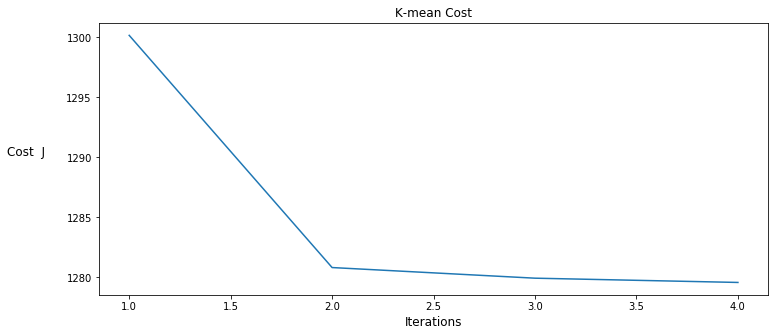

In [30]:
fig_kmean_cost = plt.figure(figsize=(12,5))
plt.plot(np.arange(i)+1, cost_k[:i])
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cost  J',rotation=0, fontsize=12, labelpad=40)
plt.title('K-mean Cost', fontsize=12)
plt.show()
         
#fig_kmean_cost.savefig('K-mean_cost.png',bbox_inches='tight')



In [20]:
k_mean_miss = 0
for i in range(data.shape[0]):
    if i < (data.shape[0]/2):
        if r_k[i,1]==1:
            k_mean_miss += 1 / data.shape[0]
    else:
        if r_k[i,0]==1:
             k_mean_miss += 1 / data.shape[0]

            
print('K-mean Misclassification Error: %.3f' %k_mean_miss)



K-mean Misclassification Error: 0.293


In [21]:
############ Problem 4 EM function #############

def normal_density(u, sigma, data):
    D = 2
    n_density = np.ones((data.shape[0],1)) * ((2*np.pi)**(-D/2))*(np.linalg.det(sigma)**(-1/2))
    
    for i in range(data.shape[0]):   
         n_density[i] = n_density[i]* (np.dot((data[i,:] - u),np.dot(np.linalg.inv(sigma),(data[i,:] - u).T)))
    
    return n_density


In [22]:
def log_likelihood(pi_1,pi_2,normal_density_1,normal_density_2):
    prob = normal_density_1 * pi_1 + normal_density_2 * pi_2
    
    return np.sum(np.log(prob))

    

In [23]:
def em_e_step(pi_1,pi_2,normal_density_1,normal_density_2):
    r = np.zeros((normal_density_1.shape[0],2))
    prob = normal_density_1 * pi_1 + normal_density_2 * pi_2
    
    r[:,0] = np.reshape(np.divide((pi_1 * normal_density_1), prob), [400,])
    r[:,1] = np.reshape(np.divide((pi_2 * normal_density_2), prob), [400,])
    
    
    return r

In [24]:
def em_m_step(r,data):
    # Update Pi
    pi_1_up = np.sum(r[:,0]) / data.shape[0]
    pi_2_up = np.sum(r[:,1]) / data.shape[0]
    
    # Update Mu
    u_1_up = (np.dot(data.T,r[:,0])) / np.sum(r[:,0])
    u_2_up = (np.dot(data.T,r[:,1])) / np.sum(r[:,1])
    
    # Update Sigma using updated Mu
    sigma_1_up = np.zeros((2,2))
    sigma_2_up = np.zeros((2,2))
    
    for i in range(data.shape[0]): 
        temp1 = np.reshape(data[i,:] - u_1_up, [2,1])
        temp2 = np.reshape(data[i,:] - u_2_up, [2,1])

        sigma_1_up += r[i,0]* np.dot(temp1,temp1.T) / np.sum(r[:,0]) 
        sigma_2_up += r[i,1]* np.dot(temp2,temp2.T) / np.sum(r[:,1]) 
    
    
    return pi_1_up, pi_2_up, u_1_up, u_2_up, sigma_1_up, sigma_2_up
    
   
    
    

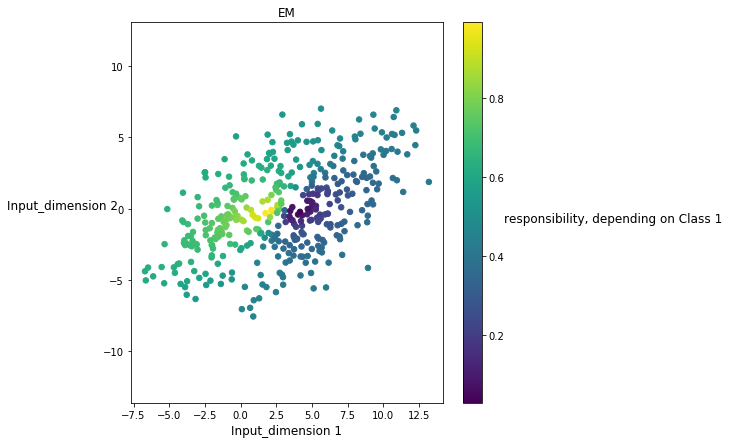

In [31]:
############ Problem 4 (C) #############

u_1_em = [0, 0]
u_2_em = [1, 1]
sigma_1_em = np.identity(2)
sigma_2_em = np.identity(2)
pi_1_em = 1/2
pi_2_em = 1/2
thres = 0.00001
l_likelihood = np.zeros((200,1))

n_density_1 = normal_density(u_1_em, sigma_1_em, data)
n_density_2 = normal_density(u_2_em, sigma_2_em, data)
    
for i in range(l_likelihood.shape[0]):
    

    r_em = em_e_step(pi_1_em,pi_2_em,n_density_1,n_density_2)

    pi_1_em, pi_2_em, u_1_em, u_2_em, sigma_1_em, sigma_2_em = em_m_step(r_em,data)
    
    n_density_1 = normal_density(u_1_em, sigma_1_em, data)
    n_density_2 = normal_density(u_2_em, sigma_2_em, data)
    
    l_likelihood[i] = log_likelihood(pi_1_em,pi_2_em,n_density_1,n_density_2)
    
    if i>0:
        if np.linalg.norm(l_likelihood[i-1] - l_likelihood[i]) < thres:
            break


fig_em = plt.figure(figsize=(7,7))

marker_size = 30
plt.scatter(data[:,0], data[:,1], marker_size, marker='o', c=r_em[:,0])

plt.title('EM', fontsize=12)
plt.xlabel('Input_dimension 1', fontsize=12)
plt.ylabel('Input_dimension 2', rotation=0, fontsize=12, labelpad=40)
cbar= plt.colorbar()
plt.axis('equal')


cbar.set_label("responsibility, depending on Class 1 ", rotation=0, fontsize=12, labelpad=110)
plt.show()
            
#fig_em.savefig('Problem4_C.png',bbox_inches='tight')
            
            
            

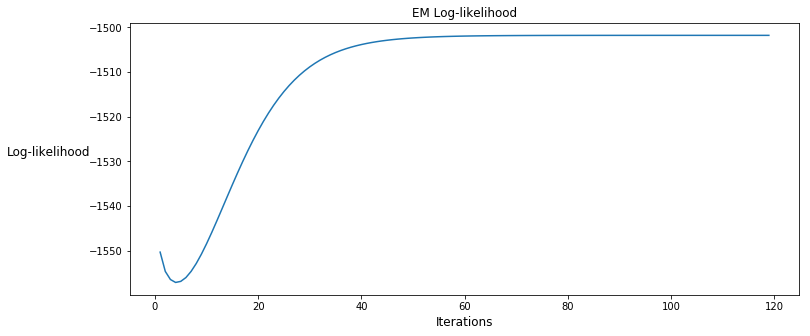

119

In [32]:
fig_em_likelihood = plt.figure(figsize=(12,5))
plt.plot(np.arange(i)+1, l_likelihood[:i])
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Log-likelihood',rotation=0, fontsize=12, labelpad=40)
plt.title('EM Log-likelihood', fontsize=12)
plt.show()
         
#fig_em_likelihood.savefig('EM_cost.png',bbox_inches='tight')
i

In [33]:
EM_miss = 0
for i in range(data.shape[0]):
    if i < (data.shape[0]/2):
        if r_em[i,0] < 0.5:
            EM_miss += 1 / data.shape[0]
    else:
        if r_em[i,1] < 0.5:            
            EM_miss += 1 / data.shape[0]


            
print('EM Misclassification Error: %.3f' %EM_miss)


EM Misclassification Error: 0.085
